# <b>TUTORIAL: Speech to text - Speaker diarization and timestamped transcript</b>

![title](images/main_sketch.png)

## Introduction

This notebook is the second of a series of tutorials. We strongly recommend you to **read the first episode** __[Speech to text - Basics]__ before doing this one, since we will use functions defined and explained in the previous episode. 

## Objective

The different steps of this second tutorial are as follow:
<ul>
    <li>Requirements</li>
    <li>Speaker diarization (Differentiate speakers)</li>
    <li>Create subtitles for videos, movies, ... (.srt file) </li>
</ul>

## Going further
**Next tutorial** will show you how to:

<ul>
    <li>Compare models and choose the best one</li>
    <li>Build a complete Streamlit application to make your code interactive.</li>
</ul>

## Step 1 - Requirements

*This notebook has been created on **AI Notebooks** with the "Miniconda- conda-py39-cuda11.2-v22-4" image.*
### A - Install and import dependencies
As the first step, let's set up the structure of our project. Several librairies need to be installed and imported. 

In [ ]:
!pip install -r requirements.txt

<br>⚠️ After installing these librairies, you may get <b>errors</b> if you try to import them directly. 
<br>To avoid that, just <b>restart the kernel</b> before the imports to make sure everything works fine. (Can be done by clicking the arrow in a circle shape above, or clicking Menu -> Kernel -> Restart kernel) 

In [1]:
# Extract sound from YouTube URL
import youtube_dl
from youtube_dl import DownloadError

# Manipulate sound
import librosa
from pydub import AudioSegment, silence
from IPython.display import Audio
import audioread

# Load models & metrics to evaluate results
from transformers import pipeline, T5Tokenizer, T5ForConditionalGeneration, Wav2Vec2Tokenizer, Wav2Vec2ForCTC 
import torch
from torchmetrics import WordErrorRate

# Others (Text & time process, system navigation)
import re
import pandas as pd
from datetime import timedelta
import os

### B - Load Pretrained models
We can now load the Wav2Vec2 model from Hugging Face (base 960h version). This model will perform the STT action.
This model is only one of many. We will in a next tutorial compare different models.

In [2]:
stt_tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
stt_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/workspace/.miniconda3/lib/python3.9/site-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:750: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


⚠️ Messages in red as below may appear throughout the execution of the code.
<br>Do not worry, these warnings are generated by the libraries and do not disturb the execution of the code.

### C - Create a folder to store the sounds we transcribe

In [3]:
dir_path = "/workspace/audio_chunks" 
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

### D - Import code from previous tutorial
All this code has been explained in the first tutorial

In [4]:
def transcribe_audio_part(filename, stt_model, stt_tokenizer, myaudio, sub_start, sub_end, index):
    """
    Transcribe an audio between a sub_start and a sub_end value (s)
    :param filename: name of the audio file
    :param stt_model: Wav2Vec2 Model (Speech to text model)
    :param stt_tokenizer: Wav2Vec2’s Tokenizer (Speech to text model's tokenizer)
    :param myaudio: AudioSegment file
    :param sub_start: start value (s) of the considered audio part to transcribe
    :param sub_end: end value (s) of the considered audio part to transcribe
    :param index: audio file counter

    :return: transcript of the considered audio (only in uppercases, so we add lower() to make the reading easier)
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    try:
        with torch.no_grad():
            new_audio = myaudio[sub_start:sub_end]  # Works in milliseconds
            path = "/workspace/audio_chunks/" + filename[:-3] + str(index) + ".mp3"
            new_audio.export(path)  # Exports to a mp3 file in the current path.
            input_audio, _ = librosa.load(path, sr=16000)

            input_values = stt_tokenizer(input_audio,
                                         return_tensors="pt").to(device).input_values  # Add padding to separate audio, padding="longest", link https://huggingface.co/transformers/v3.0.2/preprocessing.html

            logits = stt_model.to(device)(input_values).logits
            prediction = torch.argmax(logits, dim=-1)

            # Decode & add to our caption string
            transcript = stt_tokenizer.batch_decode(prediction)[0]
            return transcript.lower()

    except audioread.NoBackendError:
        # Means we have a chunk with a [value1 : value2] case with value1>value2
        print("Sorry, seems we have a problem on our side. Please change start & end values.")
        
        # Stop 
        exit()

In [60]:
def detect_silences(audio):
    # Get Decibels (dB) relative to Full Scale so silence detections depends on the audio instead of a fixed value
    dbfs = audio.dBFS
    
    # Get silences timestamps > 750ms 
    silence_list = silence.detect_silence(audio, min_silence_len=750, silence_thresh=dbfs-14)
    return silence_list

In [ ]:
def get_middle_values(silence_list):
    # Replace timestamps by their middle value
    new_silence_list=[]
    for timestamp in silence_list:
        new_silence_list.append(timestamp[0]+(timestamp[1]-timestamp[0])/2)
    return new_silence_list

In [61]:
def silences_distribution(silence_list, min_space, max_space, start, end, srt_token = False):
    """
    We keep each silence value if it is sufficiently distant from its neighboring values, without being too much
    :param silence_list: List with silence intervals
    :param min_space: Minimum temporal distance between two silences
    :param max_space: Maximum temporal distance between two silences
    :param start: int value (s) 
    :param end: int value (s) 
    :param srt_token: Enable/Disable generate srt file (choice fixed by user)
    :return: list with equally distributed silences
    """
    
    # If starts != 0, we need to adjust end value since silence detection is performed on the cropped audio (and not on the original audio)
    end -= start
    start = 0
    end *= 1000
    
    # Adding first element
    newsilence = [silence_list[0]]
    min_desired_value = silence_list[0]
    max_desired_value = silence_list[0]
    nb_values = len(silence_list)-1  # Minus one bc we have added the first element, so there is one less

    # end - newsilence[-1] > min_space
    while nb_values != 0:
        max_desired_value += max_space
        silence_window = list(filter(lambda x: min_desired_value < x <= max_desired_value, silence_list))
        if silence_window != []:
            if srt_token:
                nearest_value = min(silence_window, key=lambda x: abs(x - min_desired_value))  # 10 = 20/2
                nb_values -= silence_window.index(nearest_value) + 1  # (begins at 0, so we add 1)
            else:
                nearest_value = min(silence_window, key=lambda x: abs(x - max_desired_value))  # 10 = 20/2
                # Max value index = len of the list
                nb_values -= len(silence_window)

            if nearest_value - newsilence[-1] <= min_space:
                # If we have near values, we change the last value to the new one
                # But we need to check with the two values before if gap is > max_space (mustn't)
                if len(newsilence) >= 2:
                    if nearest_value - newsilence[-2] > max_space:
                        # Gap Too important
                        newsilence.append(nearest_value)
                    else:
                        newsilence[-1] = nearest_value
                else:
                    # There is only one value for now, we can modify it
                    newsilence.append(nearest_value)
            else:
                # If gap > min_space
                newsilence.append(nearest_value)

        else:
            newsilence.append(newsilence[-1] + max_space)  # We add the max_space to avoid multiple audio cutting

        min_desired_value = newsilence[-1]
        max_desired_value = newsilence[-1]

    final_value = end
    if final_value - newsilence[-1] > min_space:
        # Gap > Min Space
        if final_value - newsilence[-1] < max_space:
            newsilence.append(final_value)
        else:
            # Gap too important => Automatic max_space cut till the end
            newsilence = generate_regular_split(newsilence, int(end), min_space, max_space)
    else:
        # Gap < Min Space <=> Final value and last value of new silence are too close
        if len(newsilence) >= 2:
            if final_value - newsilence[-2] <= max_space:
                # Replace if gap is not too important
                newsilence[-1] = final_value
            else:
                newsilence.append(final_value)

        else:
            if final_value - newsilence[-1] <= max_space:
                # Replace if gap is not too important
                newsilence[-1] = final_value
            else:
                newsilence.append(final_value)

    if len(newsilence) >= 2:
        # Replace or Adding start
        if newsilence[0] - start < max_space:
            # Replace to avoid a transcription from 0 to 0.9s (first silence)
            newsilence[0] = start
        else:
            #Adding
            newsilence.insert(0, start)
    else:
        newsilence.insert(0, start)

    return newsilence

In [62]:
def generate_regular_split(time_list, end, min_space, max_space):
    """
    Add automatic "time cuts" to mylist till end value depending on min_space and max_space value
    :param time_list: silence time list
    :param end: int value (s)
    :param min_space: Minimum temporal distance between two silences
    :param max_space: Maximum temporal distance between two silences
    :return: list with automatic time cuts
    """
    for i in range(int(time_list[-1]), end, max_space):
        value = i + max_space
        if value < end:
            time_list.append(value)

    # Fixing last automatic cut
    # Small Gap (395 000, with end = 400 000)
    if end - time_list[-1] < min_space:
        time_list[-1] = end
    else:
        # Important gap ( 311 000 then 356 000, with end = 400 000, can't have 311k to 400k)
        time_list.append(end)
    return time_list

# Step 2 - Differentiate speakers

Now that you know the basics of speech transcription, you might be interested in the diarization. It consists in partitioning the transcript among the several persons who speak in a conversation and then improves the readability of a speech transcription.
<br><br>Indeed, you will get a transcript that looks like this: 
<br>
<blockquote>
    
Client1: What is AI Notebooks?
    
Manager: This product is a convenient, easy to use and cost effective way to adress all your data science projects. 

Client2: Will our projects be secured if they are stored in your Cloud?

Manager: It is one of our main goals in the company. As AI Notebooks is built on OVH Public Cloud, the product benefits from the A grade which ensures the security of your datas and a respect of your privacy.

Client2: Perfect, thank you!
</blockquote>

### A - Load model
This task is hard to perform, espacially when people are speaking at the same time. But it can be done thanks to pyannote library.

In [5]:
# Load diarization model
dia_pipeline = torch.hub.load('pyannote/pyannote-audio', 'dia')

Using cache found in /workspace/.cache/torch/hub/pyannote_pyannote-audio_master
Using cache found in /workspace/.cache/torch/hub/pyannote_pyannote-audio_master
Using cache found in /workspace/.cache/torch/hub/pyannote_pyannote-audio_master
Using cache found in /workspace/.cache/torch/hub/pyannote_pyannote-audio_master
/workspace/.miniconda3/lib/python3.9/site-packages/pyannote/audio/embedding/approaches/arcface_loss.py:170: FutureWarning: The 's' parameter is deprecated in favor of 'scale', and will be removed in a future release
  warnings.warn(msg, FutureWarning)
/workspace/.miniconda3/lib/python3.9/site-packages/pyannote/audio/features/pretrained.py:156: UserWarning: Model was trained with 4s chunks and is applied on 2s chunks. This might lead to sub-optimal results.
  warnings.warn(msg)
Using cache found in /workspace/.cache/torch/hub/pyannote_pyannote-audio_master


<br>⚠️ Here again, messages in red as above may appear throughout the execution of the code.
<br>Do not worry, these warnings are generated by the libraries we use and do not disturb the execution of the code.
<br><br>

### C - Load an audio file
Studying Obama's speech from first tutorial would not be interesting here as there is only one speaker in it. Try to select an audio file where several persons are speaking. This file can either be a local one, or extracted from a YouTube video like we have seen in the first tutorial.

The longer your audio is, the longer the result will.

In [ ]:
# Get an audio file where there are several speakers 
filename = "Business English B1 - B2 Participating in meetings 1 (mp3cut.net).mp3"

# Create an audio segment from it
conversation_audio = AudioSegment.from_file("/workspace/Speech_to_Text/sounds/" + filename)

### D - Convert audio file format
Once we have the diarization model loaded and our audio file, we need to **verify its format**. Indeed, pyannote's diarization <b>only accepts today </b>`.wav` format. If you send a `.mp3` or `.mp4` in the diarization algorithm, you will get errors.
<br>But do not worry, this audio format convertion can be easily done with pydub as follow: 

In [41]:
def convert_file_to_wav(aud_seg, filename):
    """
    Convert a mp3/mp4 in a wav format
    Needs to be modify if you want to convert a format which contains less or more than 3 letters

    :param aud_seg: pydub.AudioSegment
    :param filename: name of the file
    :return: name of the converted file
    """
    filename =  filename[:-3] + "wav" #folder
    file_path = "/workspace/Speech_to_Text/sounds/" + filename
    aud_seg.export(file_path, format="wav")

    newaudio = AudioSegment.from_file(file_path)

    return newaudio, filename

In [42]:
# Convert mp3/mp4 to wav (Differentiate speakers mode only accepts wav files)
if filename.endswith((".mp3", ".mp4")):
    conversation_audio, filename = convert_file_to_wav(conversation_audio, filename)

### E - Get diarization
Once the audio is converted, we can send the `.wav` audio to pyannote's diarization

In [43]:
def get_diarization(dia_pipeline, filename):
    """
    Diarize an audio (find numbers of speakers, when they speak, ...)
    :param dia_pipeline: Pyannote's library diarization model
    :param filename: name of a wav audio file
    :return: str list containing audio's diarization time intervals
    """
    # Get diarization of the audio
    diarization = dia_pipeline({'audio': "/workspace/Speech_to_Text/sounds/" + filename})
    
    # Rename default speakers' names (Default is A, B, ...), we want Speaker0, Speaker1, ...
    listmapping = diarization.labels()
    listnewmapping = []

    number_of_speakers = len(listmapping)
    for i in range(number_of_speakers):
        listnewmapping.append("Speaker" + str(i))

    mapping_dict = dict(zip(listmapping, listnewmapping))
    diarization.rename_labels(mapping_dict,
                              copy=False)  # False so we don't create a new annotation, we replace the actuel one
    return diarization, number_of_speakers

In [44]:
# Differentiate speakers process
diarization, number_of_speakers = get_diarization(dia_pipeline, filename)

/workspace/.miniconda3/lib/python3.9/site-packages/pyannote/audio/features/utils.py:179: FutureWarning: Pass orig_sr=44100, target_sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y = librosa.core.resample(y[:, 0], sample_rate, self.sample_rate)[:, None]
/workspace/.miniconda3/lib/python3.9/site-packages/pyannote/audio/features/utils.py:179: FutureWarning: Pass orig_sr=44100, target_sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y = librosa.core.resample(y[:, 0], sample_rate, self.sample_rate)[:, None]


Let's have a look to the results of diarization.

In [45]:
print(diarization)

[ 00:00:00.210 -->  00:00:01.493] L Speaker1
[ 00:00:01.694 -->  00:00:02.440] A Speaker0
[ 00:00:02.747 -->  00:00:03.133] B Speaker0
[ 00:00:03.660 -->  00:00:05.464] C Speaker0
[ 00:00:06.108 -->  00:00:07.836] D Speaker0
[ 00:00:09.036 -->  00:00:10.337] E Speaker0
[ 00:00:10.535 -->  00:00:12.612] F Speaker0
[ 00:00:14.256 -->  00:00:14.753] G Speaker0
[ 00:00:15.069 -->  00:00:20.923] H Speaker0
[ 00:00:21.308 -->  00:00:22.356] I Speaker0
[ 00:00:22.896 -->  00:00:23.798] J Speaker0
[ 00:00:24.224 -->  00:00:25.391] K Speaker0
[ 00:00:25.621 -->  00:00:28.895] M Speaker1
[ 00:00:29.414 -->  00:00:31.279] N Speaker1
[ 00:00:31.611 -->  00:00:35.061] O Speaker1
[ 00:00:35.575 -->  00:00:40.211] P Speaker1
[ 00:00:40.498 -->  00:00:42.015] Q Speaker1
[ 00:00:42.781 -->  00:00:43.532] R Speaker1
[ 00:00:43.740 -->  00:00:44.475] S Speaker1
[ 00:00:44.764 -->  00:00:47.194] T Speaker1
[ 00:00:47.530 -->  00:00:49.226] U Speaker1
[ 00:00:49.673 -->  00:00:50.322] V Speaker1
[ 00:00:50

The list is long, but you can visualize the result in a few seconds by typing the name of the variable as follow:

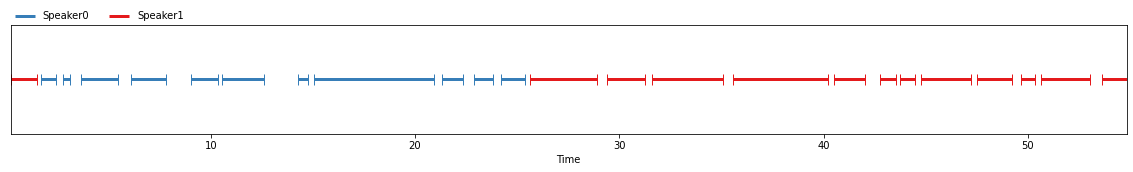

In [46]:
diarization

Pyannote does the job! As you can see, two speakers have been detected in our audio. They are represented on the sketch above in red and blue and we get the timestamps of each speaking time. Then, we know who speaks when!
As in the first episode, the idea would be to merge the timestamps of each speakers if they don't exceed a max_space value, to reduce the number of audio chunks and avoid memory problems. 

<br> To do that, we first need to convert the result of diarization into manipulable data.

In [47]:
def convert_dia_results_to_timedelta(diarization_result, start):
    """
    Extract from Diarization result the given speakers with their respective speaking times and transform them in pandas timedelta objects
    :param diarization_result: result of diarization
    :return: list with timedelta intervals and its respective speaker
    """
    
    segments = diarization_result.for_json()["content"]
    diarization_timestamps = []
    for sample in segments:

        new_seg = [pd.Timedelta(seconds = round(sample["segment"]["start"] + start, 2)), pd.Timedelta(seconds = round(sample["segment"]["end"] + start, 2)), sample["label"]]
        # Start and end = speaking duration
        # label = who is speaking
        diarization_timestamps.append(new_seg)

    return diarization_timestamps

Then, we merge the segments that follow each other and that mention the same speaker.

In [48]:
def merge_speaker_times(diarization_timestamps, max_space, srt_token = False):
    """
    Merge near times for each detected speaker. (Same speaker during 1-2s and 3-4s -> Same speaker during 1-4s)
    :param diarization_timestamps: diarization list without overlaps
    :param srt_token: Enable/Disable generate srt file (choice fixed by user)
    :return: list
    """
    if not srt_token:
        threshold = pd.Timedelta(seconds=max_space/1000)

        index = 0
        length = len(diarization_timestamps) - 1

        while index < length:
            if diarization_timestamps[index + 1][2] == diarization_timestamps[index][2] and diarization_timestamps[index + 1][0] - threshold <= diarization_timestamps[index][0]:
                diarization_timestamps[index][1] = diarization_timestamps[index + 1][1]
                del diarization_timestamps[index + 1]
                length -= 1
            else:
                index += 1
    return diarization_timestamps

<br> Finally, we try to extand the timestamps to avoid word cutting. Imagine we have a segment [00:01:20 --> 00:01:25], followed by [00:01:27 --> 00:01:30].
<br> Maybe diarizations is not working fine and there is some sound missing in the segments (means missing sound is between 00:01:25 and 00:01:27). Solution consists in fixing the end of the first segment and the start of the second one to 00:01:26, the middle of these values.

In [65]:
def extanding_timestamps(new_diarization_timestamps):
    """
    Extanding timestamps between each diarization if possible, so we avoid word cutting
    :param new_diarization_timestamps: list
    :return: list with merged times
    """
    for i in range(1, len(new_diarization_timestamps)):
        if new_diarization_timestamps[i][0] - new_diarization_timestamps[i - 1][1] <= timedelta(milliseconds=3000) and new_diarization_timestamps[i][0] - new_diarization_timestamps[i - 1][1] >= timedelta(milliseconds=100):
            middle = (new_diarization_timestamps[i][0] - new_diarization_timestamps[i - 1][1]) / 2
            new_diarization_timestamps[i][0] -= middle
            new_diarization_timestamps[i - 1][1] += middle

    # Converting list so we have a milliseconds format
    for elt in new_diarization_timestamps:
        elt[0] = elt[0].total_seconds() * 1000
        elt[1] = elt[1].total_seconds() * 1000

    return new_diarization_timestamps

Let's apply these three functions to the result of our diarization!

In [66]:
if len(diarization) > 0:
    diarization_timestamps = convert_dia_results_to_timedelta(diarization, start=0)
    diarization_timestamps = merge_speaker_times(diarization_timestamps, max_space=45000)
    diarization_timestamps = extanding_timestamps(diarization_timestamps)
    
print(diarization_timestamps)

[[210.0, 1590.0, 'Speaker1'], [1590.0, 25505.0, 'Speaker0'], [25505.0, 54840.0, 'Speaker1']]


Now that we have merged the timestamps, we can transcribe our audio!
<br>Here, we are going to create a timestamped transcript by converting the considered timestamps in displayed timedelta objects.

In [50]:
if not isinstance(diarization_timestamps[0], list):  # Only the case if only one "list" in the list (it makes a classic list) not a list of list
    diarization_timestamps = [diarization_timestamps]
    
save_result_list = []
for index, elt in enumerate(diarization_timestamps):
    sub_start = elt[0]
    sub_end = elt[1]
    
    temp_transcript = transcribe_audio_part(filename, stt_model, stt_tokenizer, conversation_audio, sub_start, sub_end,
                                              index)
    
    temp_timestamps = str(timedelta(milliseconds=sub_start)).split(".")[0] + " --> " + \
                              str(timedelta(milliseconds=sub_end)).split(".")[0] + "\n"
    complete_temp_transcript = elt[2] + ": " + temp_transcript
    
    print(temp_timestamps)
    print(complete_temp_transcript+ "\n\n")
    
    # Add result of transcript to a list, so we can use it after
    save_result_list.append([temp_timestamps, int(elt[2][-1]), elt[2], " : " + temp_transcript, int(sub_start / 1000)])

/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


0:00:00 --> 0:00:01

Speaker1: o admire over to you




/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


0:00:01 --> 0:00:25

Speaker0: akes markus well i've prepared some handouts to show you how the figures are looking if we look at sails year to date so in order to meet budget this year we will in my opinion have to start some cost saving measures what do you mean by that redundancies that's one possibility




/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


0:00:25 --> 0:00:54

Speaker1: i can't agree with you there we need a strong work for us oka thanks myr the cos cutting is something that we need to think about but we also need to stop the downturn in sales and regain marketshire so can i bring you in here david any comments well it's hard to know what the problem is our products are competitive so they're not getting better offers from the competition i don't think so




Result seems good, but if you listen to the audio, you will notice that it is not perfect. Indeed, this audio contains more than 2 speakers which means pyannote has confused interlocutors. 
<Br>However, it is important to remember that our audio is only one minute long, which is very hard to analyse because each speaker does not have so much time to speak. The error rate is therefore more important. We need more data so it will work better if the file is longer.
    
=> Peut-être plutôt faire cette partie sur un audio + long pour montrer que ça peut mieux fonctionner justement? 

In [69]:
#Parfois il y a un warning huggingface/tokenizers: The current process just got forked, after parallelism has already been used.

# peut être résolu par les 2 lignes suivantes
#os.environ["TOKENIZERS_PARALLELISM"] = false / true ? 

### B - Rename speakers
Of course, it would be interesting to have the possibility to rename the detected speakers in the audio file. Indeed, having Speaker0, Speaker1, ... is fine but it could be so much better! Guess what? We are going to do this! 
<br>We are going to create a list where we add each speaker with his 'ID'. It is important to sort the list because we want the smallest ID at the beginning of our list, so we don't exchange names between speakers. 

In [53]:
if number_of_speakers > 0:
    # Saving the Speaker Name and its ID in a list, example : [1, 'Speaker1']
    list_of_speakers = []
    for elt in save_result_list:        
        if [elt[1], elt[2]] not in list_of_speakers:
            list_of_speakers.append([elt[1], elt[2]])

    # Sorting (by ID)
    list_of_speakers.sort()  # Sort id by ID so we do not have an unsorted case like [1, 'Speaker1'], [0, 'Speaker0']]
    print(list_of_speakers)

[[0, 'Speaker0'], [1, 'Speaker1']]


As you can see, we have the two detected speakers with their respective name and ID.
Now, let's rename the names of our speakers as 'You' and 'Me' like we are having a conversation!

In [54]:
# Do not change the name_index value. It indicates the index of the name if the list_of_speakers list.
name_index = 1

# Change names
list_of_speakers[0][name_index] = "You"
list_of_speakers[1][name_index] = "Me"

Everything is ready! We just have to apply the changes to our initial save_result list, and print the transcript again!

In [55]:
for elt in save_result_list:
    elt[2] = list_of_speakers[elt[1]][1]
    print(elt[0], elt[2] + elt[3] + "\n", sep='')

0:00:00 --> 0:00:01
Me : o admire over to you

0:00:01 --> 0:00:25
You : akes markus well i've prepared some handouts to show you how the figures are looking if we look at sails year to date so in order to meet budget this year we will in my opinion have to start some cost saving measures what do you mean by that redundancies that's one possibility

0:00:25 --> 0:00:54
Me : i can't agree with you there we need a strong work for us oka thanks myr the cos cutting is something that we need to think about but we also need to stop the downturn in sales and regain marketshire so can i bring you in here david any comments well it's hard to know what the problem is our products are competitive so they're not getting better offers from the competition i don't think so



Congratulations, you now have the transcript of a conversation between your own interlocutors with their speaking timestamps! 

# Step 8 : Create a SRT transcript (subtitles for videos)

We just saw that we can create a timestamped transcript instead of creating a simple transcript.txt. That could help us to create subtitles for videos for your viewers or even deaf persons! 
<br>Idea is very simple here, process is the same as before. We just have to shorten the timestamps, so the transcript is synchronized with the video. Indeed, a 30s timestamp will be accompanied by a lot of text as shown in the left figure below, which spoils the visual effect of the subtitle synchronization. We want to have 10s maximum timestamps, which means short texts which each will move to the next one, like the right figure below.

![title](images/srt_figure.png)

<br><br>To do that, we just have to modify the minimum and maximum length (minimum and max_space) values!

In [56]:
# Tiny time intervals if we want a short text
min_space = 1000  # 1 sec
max_space = 8000  # 8 secs

Once this is done, we just have to set the srt_token to True, to adapt the code and create short intervals instead of the largest ones as possible. Then, you can either choose the silence detection or the diarization method. SRT transcription works with both, but it makes more sense if you opt for the silence detection, as it is faster to process and does not give you the information about who is speaking when, thing that we do not need because of the video.

### Trim an audio
Let's do this on obama's speech again! (but only on the first minute of speech so we don't get a massive output)

In [58]:
# parameters 

# Trim from 0s to 58s
start = 0
end = 58

obama_audio = AudioSegment.from_file("/workspace/Speech_to_Text/sounds/obama.mp3")
obama_audio = obama_audio[start*1000:end*1000]  # Works in milliseconds (*1000)

srt_token = True

### Generate .srt transcript

In [63]:
# detect silences and silences treatment
srt_silence_list = detect_silences(obama_audio)
srt_new_silence_list=get_middle_values(srt_silence_list)
srt_new_silence_list2 = silences_distribution(srt_new_silence_list, min_space, max_space, start, end, srt_token)

# transcribe audio and obtain subtitles
srt_transcript = ""
for i in range(0, len(srt_new_silence_list2) - 1):
    sub_start = srt_new_silence_list2[i]
    sub_end = srt_new_silence_list2[i + 1]

    # Initial audio has been split with start & end values
    # It begins to 0s, but the timestamps need to be adjust with +start*1000 values to adapt the gap

    transcript = transcribe_audio_part(filename, stt_model, stt_tokenizer, obama_audio, sub_start, sub_end, i) + " "
    srt_transcript += str(i) + "\n" + str(timedelta(milliseconds=sub_start)).split(".")[0] + " --> " + str(timedelta(milliseconds=sub_end)).split(".")[0] + "\n" + transcript + "\n\n"

/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*ar

0
0:00:00 --> 0:00:03
por even as we celebrate to night 

1
0:00:03 --> 0:00:07
we know the challenges that to morrow will bring 

2
0:00:07 --> 0:00:10
are the greatest of our lifeton 

3
0:00:10 --> 0:00:17
i stand here knowing that my story is part of the larger american story that 

4
0:00:17 --> 0:00:25
i owe a debt to all of those who came before me and that in no other country on earth is my story even possible 

5
0:00:25 --> 0:00:26
 

6
0:00:26 --> 0:00:34
i am the son of a black man from canya and a white woman from kansas i am married to a 

7
0:00:34 --> 0:00:42
black american who carries within her the blood of slaves and slave owners i have brothers sisters nieces nephews uncles 

8
0:00:42 --> 0:00:50
and cousins of every race and every hue scattered across three countenents these people are part of me 

9
0:00:50 --> 0:00:58
and they are part of america this country that i love 




Are you ready? Let's take a look at our subtitles!

In [64]:
print(srt_transcript)

0
0:00:00 --> 0:00:03
por even as we celebrate to night 

1
0:00:03 --> 0:00:07
we know the challenges that to morrow will bring 

2
0:00:07 --> 0:00:10
are the greatest of our lifeton 

3
0:00:10 --> 0:00:17
i stand here knowing that my story is part of the larger american story that 

4
0:00:17 --> 0:00:25
i owe a debt to all of those who came before me and that in no other country on earth is my story even possible 

5
0:00:25 --> 0:00:26
 

6
0:00:26 --> 0:00:34
i am the son of a black man from canya and a white woman from kansas i am married to a 

7
0:00:34 --> 0:00:42
black american who carries within her the blood of slaves and slave owners i have brothers sisters nieces nephews uncles 

8
0:00:42 --> 0:00:50
and cousins of every race and every hue scattered across three countenents these people are part of me 

9
0:00:50 --> 0:00:58
and they are part of america this country that i love 




### Export timestamped transcript as .srt file

Now, you can export this timestamped transcript in a .srt file. Then, you will be able to import this file on a compatible media player software and follow your video with subtitles!

In [49]:
with open('/workspace/Speech_to_Text/saved_transcripts/transcript.srt', 'w+') as f:
    f.write(srt_transcript)

Your transcript is now saved! 

## Conclusion
<br>I hope you have enjoyed this tutorial!
<br>You are now capable of creating a transcript with a speaker differentiation (diarization) and a timestamped transcript to generate video's subtitles!
<br><br>You can check our **next tutorials** by clicking here to learn how to:

<ul>
    <li>Compare models and choose the best one</li>
    <li>Build a complete Streamlit application to make your code interactive.</li>
</ul>